# 1. COLLECTED DATA
Avaibility data quantity and quality control 



### Init libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

# avoid displaying warnings 
import warnings
warnings.filterwarnings("ignore")

### 1. Collect data

In [2]:
data = pd.read_csv("medical.csv", sep=';')


In [3]:
# Show first lines (head)
print(data.head(10))

           Disease Fever Cough Fatigue Difficulty Breathing  Age  Gender  \
0        Influenza   Yes    No     Yes                  Yes   19  Female   
1      Common Cold    No   Yes     Yes                   No   25  Female   
2           Eczema    No   Yes     Yes                   No   25  Female   
3           Asthma   Yes   Yes      No                  Yes   25    Male   
4           Asthma   Yes   Yes      No                  Yes   25    Male   
5           Eczema   Yes    No      No                   No   25  Female   
6        Influenza   Yes   Yes     Yes                  Yes   25  Female   
7        Influenza   Yes   Yes     Yes                  Yes   25  Female   
8  Hyperthyroidism    No   Yes      No                   No   28  Female   
9  Hyperthyroidism    No   Yes      No                   No   28  Female   

  Blood Pressure Cholesterol Level Outcome Variable  
0            Low            Normal         Positive  
1         Normal            Normal         Negative  
2

In [4]:
# Informations about data type and length
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Disease               349 non-null    object
 1   Fever                 349 non-null    object
 2   Cough                 349 non-null    object
 3   Fatigue               349 non-null    object
 4   Difficulty Breathing  349 non-null    object
 5   Age                   349 non-null    int64 
 6   Gender                349 non-null    object
 7   Blood Pressure        349 non-null    object
 8   Cholesterol Level     349 non-null    object
 9   Outcome Variable      349 non-null    object
dtypes: int64(1), object(9)
memory usage: 27.4+ KB


In [5]:
#Data structure
data.describe()

,Age
count,349.000000
mean,46.323782
std,13.085090
min,19.000000
25%,35.000000
50%,45.000000
75%,55.000000
max,90.000000


In [6]:
# Checking all the missing value in the data 
data.isnull().sum()

Disease                 0
Fever                   0
Cough                   0
Fatigue                 0
Difficulty Breathing    0
Age                     0
Gender                  0
Blood Pressure          0
Cholesterol Level       0
Outcome Variable        0
dtype: int64

### Cleaning and preparing the data
 

By Marina

#### 2. Cleaning


In [7]:
# A) Drop the missing values
df = data.dropna()

In [8]:
# B) Verify distributong disease
print(df["Disease"].value_counts())  


Disease
Asthma               23
Stroke               16
Osteoporosis         14
Diabetes             10
Hypertension         10
                     ..
Schizophrenia         1
Gout                  1
Testicular Cancer     1
Tonsillitis           1
Williams Syndrome     1
Name: count, Length: 116, dtype: int64


In [9]:
encoder = LabelEncoder()
df["Disease"] = encoder.fit_transform(df["Disease"])  # Transformer les maladies en nombres
df["Gender"] = encoder.fit_transform(df["Gender"])  # Transformer Male/Female en 0/1

In [10]:
df.head(10)

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,56,Yes,No,Yes,Yes,19,0,Low,Normal,Positive
1,24,No,Yes,Yes,No,25,0,Normal,Normal,Negative
2,37,No,Yes,Yes,No,25,0,Normal,Normal,Negative
3,6,Yes,Yes,No,Yes,25,1,Normal,Normal,Positive
4,6,Yes,Yes,No,Yes,25,1,Normal,Normal,Positive
5,37,Yes,No,No,No,25,0,Normal,Normal,Positive
6,56,Yes,Yes,Yes,Yes,25,0,Normal,Normal,Positive
7,56,Yes,Yes,Yes,Yes,25,0,Normal,Normal,Positive
8,53,No,Yes,No,No,28,0,Normal,Normal,Negative
9,53,No,Yes,No,No,28,0,Normal,Normal,Negative


In [11]:
df.replace({"Yes": 1, "No": 0}, inplace=True)


In [12]:
print(df.dtypes)


Disease                  int64
Fever                    int64
Cough                    int64
Fatigue                  int64
Difficulty Breathing     int64
Age                      int64
Gender                   int64
Blood Pressure          object
Cholesterol Level       object
Outcome Variable        object
dtype: object


In [13]:
categorical_columns = ["Blood Pressure", "Cholesterol Level", "Outcome Variable"]

# Appliquer LabelEncoder à chaque colonne
encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

In [14]:
print(df.dtypes)  # Toutes les colonnes doivent être int64 ou float64
print(df.head())  # Vérifier les valeurs transformées


Disease                 int64
Fever                   int64
Cough                   int64
Fatigue                 int64
Difficulty Breathing    int64
Age                     int64
Gender                  int64
Blood Pressure          int64
Cholesterol Level       int64
Outcome Variable        int64
dtype: object
   Disease  Fever  Cough  Fatigue  Difficulty Breathing  Age  Gender  \
0       56      1      0        1                     1   19       0   
1       24      0      1        1                     0   25       0   
2       37      0      1        1                     0   25       0   
3        6      1      1        0                     1   25       1   
4        6      1      1        0                     1   25       1   

   Blood Pressure  Cholesterol Level  Outcome Variable  
0               1                  2                 1  
1               2                  2                 0  
2               2                  2                 0  
3               2        

In [15]:
X = df.drop(columns=["Disease"])  # Caractéristiques
y = df["Disease"]  # Cible


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)  # Entraînement
    y_pred = model.predict(X_test)  # Prédiction
    acc = accuracy_score(y_test, y_pred)  # Score de précision
    print(f"{name} Accuracy: {acc:.2f}")

Random Forest Accuracy: 0.31
SVM Accuracy: 0.14
KNN Accuracy: 0.13
Logistic Regression Accuracy: 0.19
Decision Tree Accuracy: 0.24
Gradient Boosting Accuracy: 0.26


In [19]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)
print("Meilleur modèle:", grid.best_params_)

Meilleur modèle: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


In [20]:
best_model = RandomForestClassifier(
    max_depth=None,
    min_samples_split=2,
    n_estimators=50,
    random_state=42
)

best_model.fit(X_train, y_train)  
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Optimized Random Forest Accuracy: {acc:.2f}")

Optimized Random Forest Accuracy: 0.30


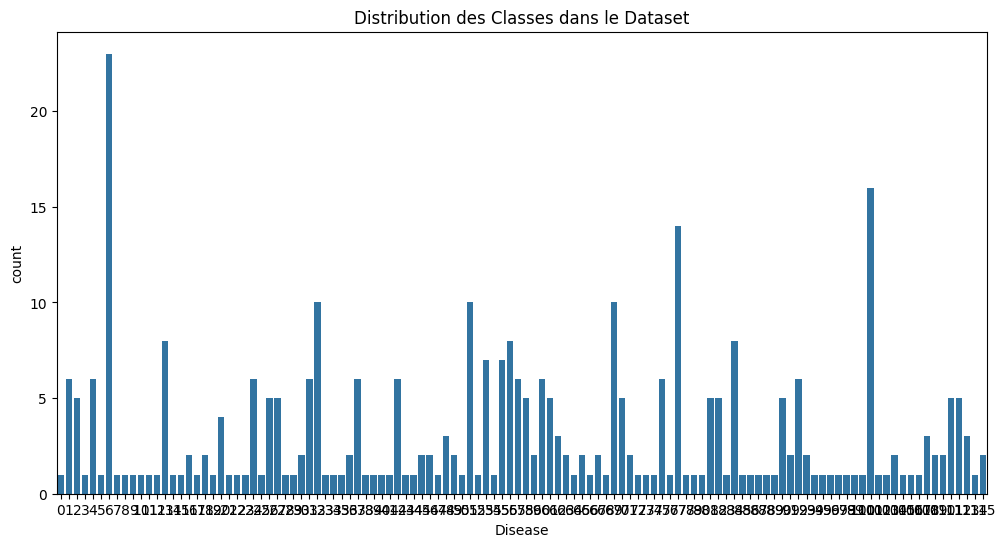

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(x=y)
plt.title("Distribution des Classes dans le Dataset")
plt.show()

In [22]:
print(df.isnull().sum())


Disease                 0
Fever                   0
Cough                   0
Fatigue                 0
Difficulty Breathing    0
Age                     0
Gender                  0
Blood Pressure          0
Cholesterol Level       0
Outcome Variable        0
dtype: int64


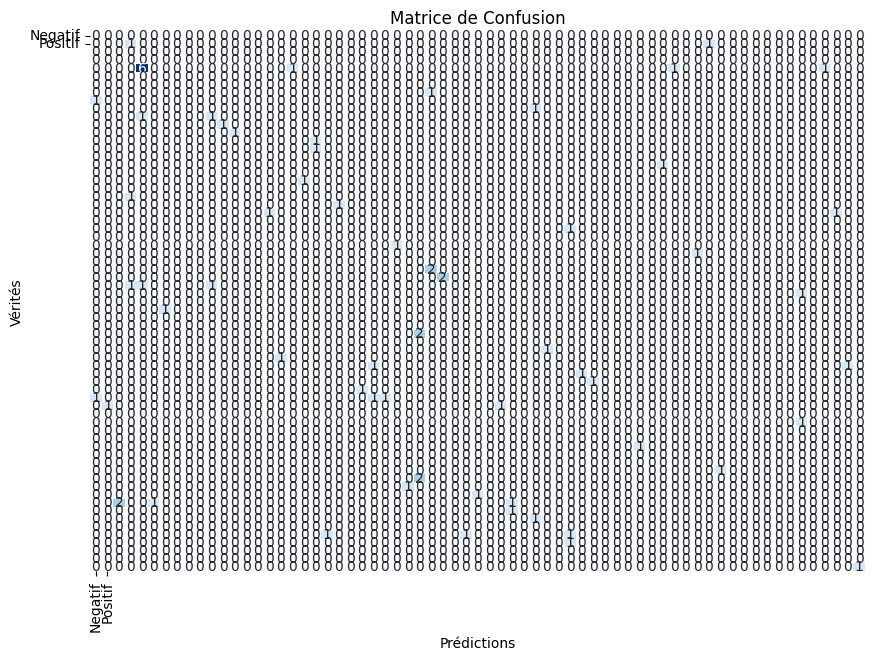

In [23]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Créer une carte thermique (heatmap) pour la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de Confusion")
plt.show()



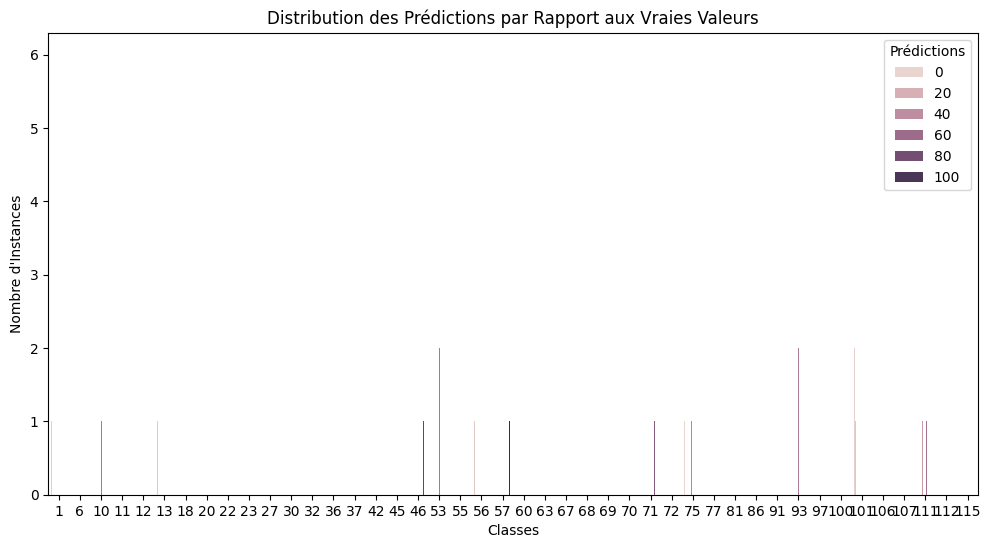

In [24]:
results_df = pd.DataFrame({'Vraies Valeurs': y_test, 'Prédictions': y_pred})

# Tracer la distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=results_df, x='Vraies Valeurs', hue='Prédictions')
plt.title("Distribution des Prédictions par Rapport aux Vraies Valeurs")
plt.xlabel("Classes")
plt.ylabel("Nombre d'Instances")
plt.legend(title='Prédictions', loc='upper right')
plt.show()


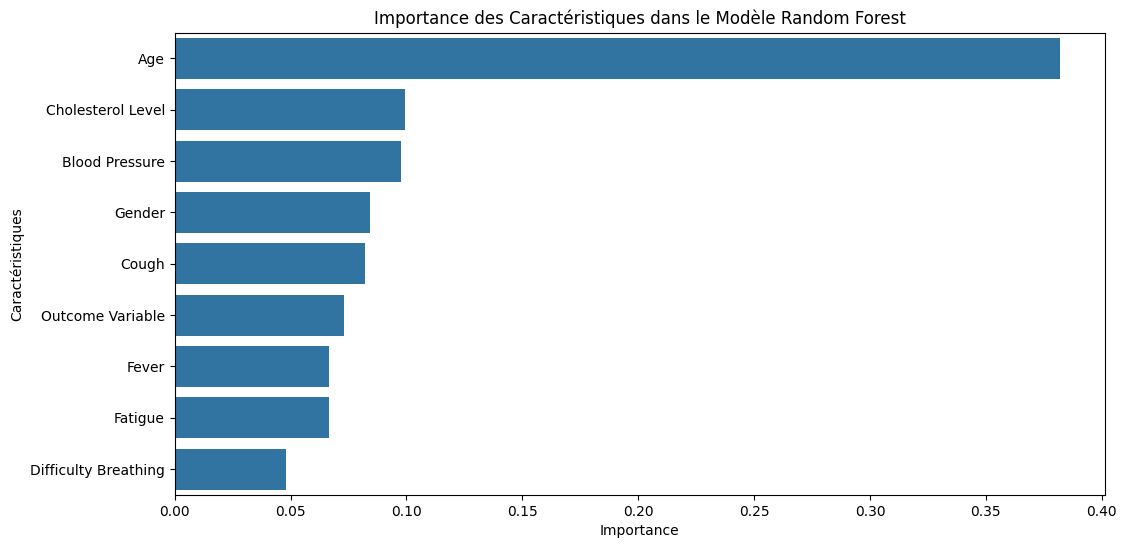

In [25]:
# Importance des caractéristiques
importances = best_model.feature_importances_
features = X.columns  # Remplace X par ton DataFrame d'origine

# Créer un DataFrame pour l'importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Tracer l'importance des caractéristiques
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Importance des Caractéristiques dans le Modèle Random Forest")
plt.xlabel("Importance")
plt.ylabel("Caractéristiques")
plt.show()


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.75      0.67      0.71         9
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.50      0.50      0.50         2
          18       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         1
          22       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         0
          27       0.00      0.00      0.00         1
          28       0.00    

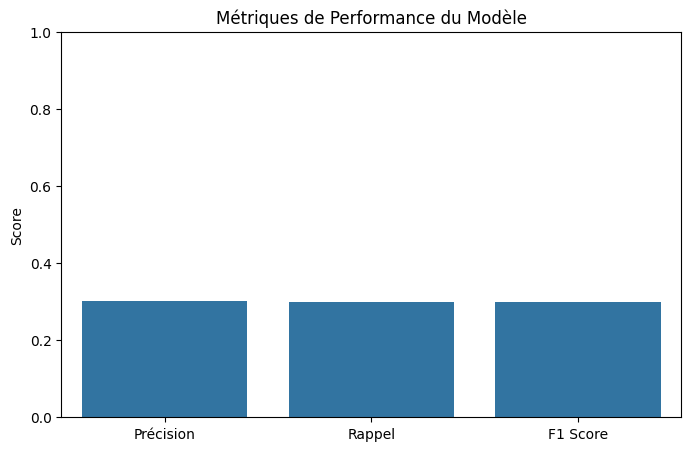

In [27]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Afficher les résultats
plt.figure(figsize=(8, 5))
metrics = ['Précision', 'Rappel', 'F1 Score']
values = [precision, recall, f1]

sns.barplot(x=metrics, y=values)
plt.title("Métriques de Performance du Modèle")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()